In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import MultiHeadAttention
from keras.preprocessing.image import ImageDataGenerator

In [2]:
# Load the model from the H5 file
loaded_model = load_model('densenet201_model.h5')

# Print the shape of the feature extraction layer for debugging
print("Feature Shape:", loaded_model.layers[-3].output_shape[1:])

Feature Shape: (64,)


In [3]:
train_path = './train'
test_path = './test'
val_path = './val'

In [4]:
size_images = 150
batch_size = 32

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,                # Rescale pixel values to [0, 1]
)
train_generator = train_datagen.flow_from_directory(
    train_path,                     # Path to the training data
    target_size=(size_images, size_images),  # Resize images to this size
    batch_size = batch_size,        # Number of images in each batch
    class_mode ='categorical'       # Mode for class labels (categorical for one-hot encoding)
)

test_datagen = ImageDataGenerator(rescale=1.0/255)
test_generator = test_datagen.flow_from_directory(
    test_path,
    target_size=(size_images, size_images),
    batch_size = batch_size,
    class_mode='categorical')

val_datagen = ImageDataGenerator(rescale=1.0/255)

val_generator = val_datagen.flow_from_directory(
    val_path,
    target_size=(size_images, size_images),
    batch_size=batch_size,
    class_mode='categorical'
)

Found 31571 images belonging to 4 classes.
Found 6769 images belonging to 4 classes.
Found 6765 images belonging to 4 classes.


In [6]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
# Define a learning rate schedule function
def lr_schedule(epoch):
    initial_lr = 0.001
    drop = 0.5
    epochs_drop = 5
    lr = initial_lr * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lr

early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=5,
    restore_best_weights=True,
)

# Use the LearningRateScheduler callback
lr_callback = LearningRateScheduler(lr_schedule)

In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.layers import MultiHeadAttention
from tensorflow.keras.optimizers import Adam
# Assuming you have a pre-trained feature extractor model (e.g., a CNN)
pretrained_feature_extractor = loaded_model.layers[-3]

# Get the output shape of the feature extraction layer
feature_shape = pretrained_feature_extractor.output_shape[1:]

base_model = models.Model(inputs=loaded_model.input, outputs=loaded_model.layers[-3].output)
# Print the shape for debugging
print("Feature Shape:", feature_shape)

Feature Shape: (64,)


In [8]:
# Define your transformer model
def transformer_model(input_shape, num_transformer_layers, output_dim):
    inputs = tf.keras.Input(shape=input_shape)
    
    # Add a "sequence_length" dimension to the input
    sequence = layers.Reshape((1, input_shape[0]))(inputs)
    
    # Transformer layers using MultiHeadAttention
    sequence = MultiHeadAttention(num_heads=5, key_dim=64)(sequence, sequence)
    sequence = layers.LayerNormalization(epsilon=1e-6)(sequence)
    sequence = layers.Dropout(0.1)(sequence)
    
    # Reshape the sequence to maintain 3D structure
    sequence = layers.Reshape((-1, feature_shape[0]))(sequence)
    
    # Output layer for your specific task
    outputs = layers.Dense(output_dim, activation='softmax')(sequence)
    
    model = models.Model(inputs=inputs, outputs=outputs)
    return model

# Define your task-specific output dimension (e.g., number of classes)
output_dim = 4
num_tlayers = 2

# Create the transformer model
transformer = transformer_model(input_shape=feature_shape, num_transformer_layers=num_tlayers, output_dim=output_dim)

# Print the summary of the model for debugging
transformer.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 64)]         0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, 64)        0           input_1[0][0]                    
__________________________________________________________________________________________________
multi_head_attention (MultiHead (None, 1, 64)        82944       reshape[0][0]                    
                                                                 reshape[0][0]                    
__________________________________________________________________________________________________
layer_normalization (LayerNorma (None, 1, 64)        128         multi_head_attention[0][0] 

In [9]:
# Combine the pre-trained feature extractor with the transformer
combined_model = models.Sequential([
    base_model,
    transformer,
    layers.Flatten()  # Add Flatten layer to reshape the output
])

# Compile the model (adjust loss and metrics based on your task)
combined_model.compile(optimizer=Adam(learning_rate=0.000005), loss='categorical_crossentropy', metrics=['accuracy'])

# Print the summary of the combined model
combined_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 64)                26227712  
_________________________________________________________________
model_1 (Functional)         (None, 1, 4)              83332     
_________________________________________________________________
flatten (Flatten)            (None, 4)                 0         
Total params: 26,311,044
Trainable params: 26,081,988
Non-trainable params: 229,056
_________________________________________________________________


In [10]:
# Train the model
import math
history = combined_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=20,
    validation_data=val_generator,
    validation_steps=val_generator.samples // batch_size,
    callbacks=[early_stopping, lr_callback]
)

Epoch 1/20
986/986 [==============================] - 312s 277ms/step - loss: 0.1270 - accuracy: 0.9629 - val_loss: 0.4896 - val_accuracy: 0.8866
Epoch 2/20
986/986 [==============================] - 253s 257ms/step - loss: 0.0958 - accuracy: 0.9691 - val_loss: 0.3433 - val_accuracy: 0.8972
Epoch 3/20
986/986 [==============================] - 259s 263ms/step - loss: 0.1004 - accuracy: 0.9672 - val_loss: 1.3593 - val_accuracy: 0.6537
Epoch 4/20
986/986 [==============================] - 260s 264ms/step - loss: 0.0803 - accuracy: 0.9742 - val_loss: 1.0555 - val_accuracy: 0.6958
Epoch 5/20
986/986 [==============================] - 265s 268ms/step - loss: 0.0410 - accuracy: 0.9869 - val_loss: 0.0638 - val_accuracy: 0.9790
Epoch 6/20
986/986 [==============================] - 273s 276ms/step - loss: 0.0395 - accuracy: 0.9879 - val_loss: 0.0997 - val_accuracy: 0.9704
Epoch 7/20
986/986 [==============================] - 275s 278ms/step - loss: 0.0373 - accuracy: 0.9881 - val_loss: 0.0342 -

In [11]:
test_results = combined_model.evaluate(test_generator, steps=test_generator.samples // batch_size)
print("Test Loss:", test_results[0])
print("Test Accuracy:", test_results[1])

211/211 [==============================] - 33s 154ms/step - loss: 0.0096 - accuracy: 0.9966
Test Loss: 0.009622241370379925
Test Accuracy: 0.9965935945510864


In [22]:
combined_model.save('densenet201_vit_model.h5')

In [23]:
import numpy as np

loaded_model = load_model('densenet201_vit_model.h5')

# Initialize lists to accumulate predictions and true labels
all_predictions = []
all_true_labels = []

# Loop through all batches in the test generator
for _ in range(len(test_generator)):
    images, labels = test_generator.next()

    # Predictions on the current batch
    batch_predictions = loaded_model.predict(images)
    all_predictions.extend(batch_predictions)
    
    # True labels for the current batch
    batch_true_labels = np.argmax(labels, axis=1)
    all_true_labels.extend(batch_true_labels)

# Convert lists to numpy arrays
all_predictions = np.array(all_predictions)
all_true_labels = np.array(all_true_labels)

# Extract predicted labels from all predictions
predicted_labels = np.argmax(all_predictions, axis=1)

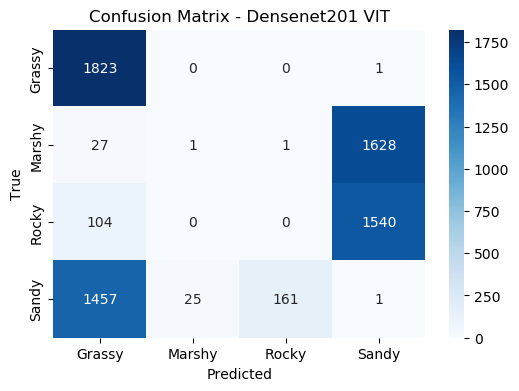

In [25]:
# Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
conf_mat = confusion_matrix(all_true_labels, predicted_labels)

# Plot the confusion matrix
class_names = ['Grassy', 'Marshy', 'Rocky', 'Sandy']  # Update with your actual class names
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Densenet201 VIT')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [26]:

# Classification Report
print("Classification Report of Densenet 201 VIT:")
print(classification_report(all_true_labels, predicted_labels, target_names=class_names))


Classification Report of Densenet 201 VIT:
              precision    recall  f1-score   support

      Grassy       0.53      1.00      0.70      1824
      Marshy       0.04      0.00      0.00      1657
       Rocky       0.00      0.00      0.00      1644
       Sandy       0.00      0.00      0.00      1644

    accuracy                           0.27      6769
   macro avg       0.14      0.25      0.17      6769
weighted avg       0.15      0.27      0.19      6769



In [27]:
# Calculate percentage of correct predictions for each class
correctly_classified = np.diag(conf_mat)
total_true_per_class = np.sum(conf_mat, axis=1)
percentage_correct_per_class = (correctly_classified / total_true_per_class) * 100

# Display the percentage of correct predictions for each class
for i, class_name in enumerate(class_names):
    print(f'Percentage of correct predictions for {class_name}: {percentage_correct_per_class[i]:.2f}%')


Percentage of correct predictions for Grassy: 99.95%
Percentage of correct predictions for Marshy: 0.06%
Percentage of correct predictions for Rocky: 0.00%
Percentage of correct predictions for Sandy: 0.06%


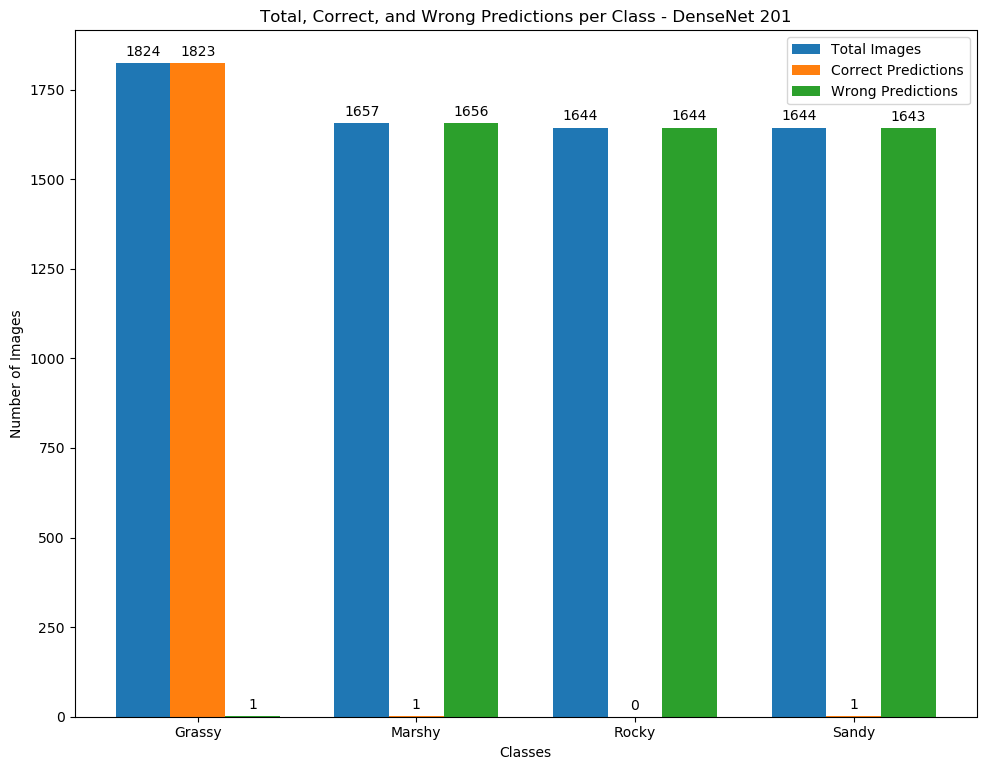

In [28]:
class_names = ['Grassy', 'Marshy', 'Rocky', 'Sandy']  # Update with your actual class names

# Print the number of images classified correctly and wrongly in each class
correctly_classified = np.diag(conf_mat)
wrongly_classified = np.sum(conf_mat, axis=1) - correctly_classified

# Total number of images in each class
total_images_per_class = np.sum(conf_mat, axis=1)

x = np.arange(len(class_names))
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width, total_images_per_class, width, label='Total Images')
rects2 = ax.bar(x, correctly_classified, width, label='Correct Predictions')
rects3 = ax.bar(x + width, wrongly_classified, width, label='Wrong Predictions')

ax.set_xlabel('Classes')
ax.set_ylabel('Number of Images')
ax.set_title('Total, Correct, and Wrong Predictions per Class - DenseNet 201')
ax.set_xticks(x)
ax.set_xticklabels(class_names)
ax.legend()

# Display the number of images on top of each bar with proper spacing
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

# Adjust layout to prevent overlapping
plt.tight_layout(rect=[0, 0, 1, 1.3])  # Increase the value in the last argument if necessary

plt.show()